# VAE Analysis

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
RUN_ID = '0002'
RUN_FOLDER = os.path.join("./run", RUN_ID)
DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [4]:
INPUT_DIM = (64,64,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [5]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [6]:
VAE = load_model(VariationalAutoencoder, RUN_FOLDER)

## reconstructing faces

Found 202599 images.


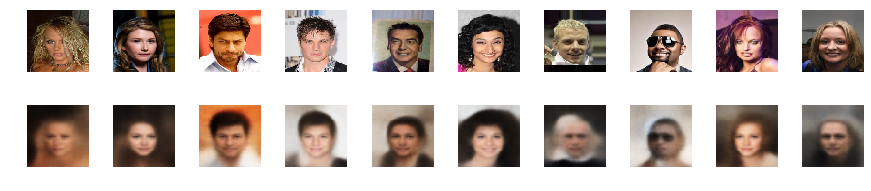

In [7]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = VAE.encoder.predict(example_images)

reconst_images = VAE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 1s 56ms/step


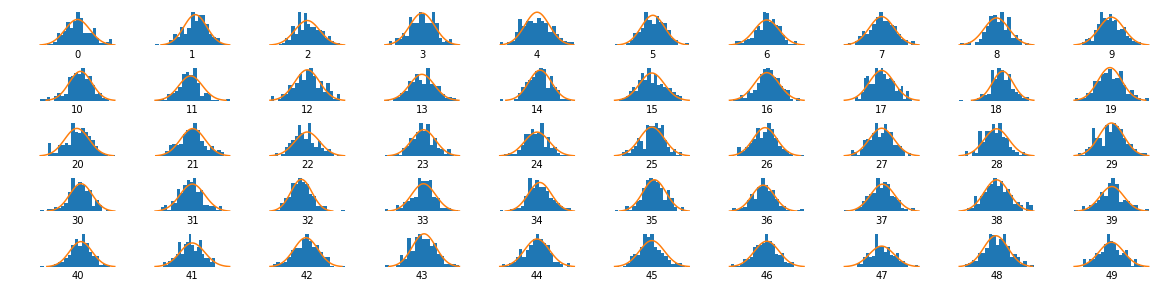

In [19]:
z_test = VAE.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(20, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

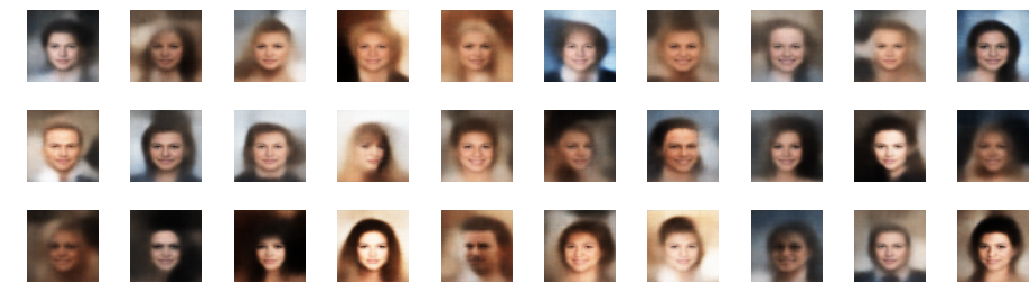

In [8]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,VAE.z_dim))

reconst = VAE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [9]:
def get_vector_from_label(label, batch_size, imageLoader):
    
    data_flow_label = imageLoader.build(att, BATCH_SIZE, label = label)

    origin = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_sum_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_n_NEG = 0
    current_mean_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_mean_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_dist = 0
    
    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        label = batch[1]

        z = VAE.encoder.predict(np.array(im))


        z_POS = z[label==1]
        z_NEG = z[label==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)
            
        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.05:
            current_vector = current_vector / current_dist
            break

    print('Found the ' + LABEL + ' vector')
    return current_vector   


In [10]:
BATCH_SIZE = 1000
LABEL = 'Smiling'

feature_vec = get_vector_from_label(LABEL, BATCH_SIZE, imageLoader)

Found 202599 images.
label: Smiling
images : POS move : NEG move :distance : 𝛥 distance
466    : 0.641    : 0.754    : 1.188    : 1.188


KeyboardInterrupt: 

NameError: name 'feature_vec' is not defined

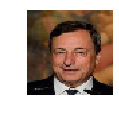

In [11]:
n_to_show = 5
factors = [-4,-3,-2,-1,0,1,2,3,4]

example_batch = next(data_flow_generic)
example_images = example_batch[0]
example_labels = example_batch[1]

z_points = VAE.encoder.predict(example_images)

fig = plt.figure(figsize=(18, 10))

counter = 1

for i in range(n_to_show):
    
    img = example_images[i].squeeze()
    sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
    sub.axis('off')        
    sub.imshow(img)
    
    counter += 1
    
    for factor in factors:
        
        changed_z_point = z_points[i] + feature_vec * factor
        changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]
        
        img = changed_image.squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')
        sub.imshow(img)
        
        counter += 1
        
plt.show()


In [17]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = VAE.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 images.


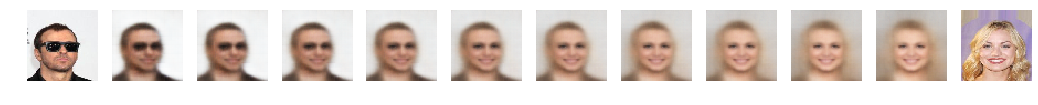

In [18]:
start_image_file = '000382.jpg'
end_image_file = '000193.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


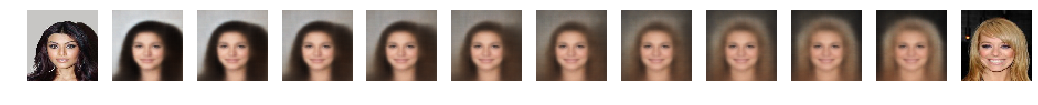

In [19]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)